In [1]:
import numpy as np
import torch
import torchvision
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
device

device(type='cuda')

In [4]:
class DenoisingConvAutoEncoder(nn.Module):
    
    def __init__(self):
        super(DenoisingConvAutoEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=(1, 1))
        self.pool1 = nn.MaxPool2d(2, return_indices=True)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1, 1))
        self.tconv1 = nn.ConvTranspose2d(32, 32, 3, padding = (1, 1))
        self.unpool1 = nn.MaxUnpool2d((2, 2))
        self.tconv2 = nn.ConvTranspose2d(32, 1, 3, padding = (1, 1))
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x, indices = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.tconv1(x))
        x = self.unpool1(x, indices)
        x = F.relu(self.tconv2(x))
        return x

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

In [6]:
train_dataset = torchvision.datasets.MNIST(root = './', 
                                           train = True,
                                           download = True,
                                           transform = transform)
val_dataset = torchvision.datasets.MNIST(root = './', 
                                           train = False,
                                           download = True,
                                           transform = transform)

In [7]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     num_workers=2,
                                     pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     num_workers=2,
                                     pin_memory=True)

In [8]:
def addGaussianNoise(x, eps):
    return x + eps*torch.randn_like(x)

def getRandomMask(data, size):
    mask = torch.ones_like(data)
    n, c, h, w = mask.shape
    x = torch.randint(low = 0, high = h - size, size = (1, 1))
    y = torch.randint(low = 0, high = w - size, size = (1, 1))
    mask[:, :, x : x + size, y : y + size] = 0
    return mask, x, y

def getMask(data, size, x, y):
    mask = torch.ones_like(data)
    n, c, h, w = mask.shape
    mask[:, :, x : x + size, y : y + size] = 0
    return mask

In [28]:
model = DenoisingConvAutoEncoder()
model.to(device)

DenoisingConvAutoEncoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (tconv1): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (unpool1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (tconv2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [29]:
criterion = nn.L1Loss(reduction = 'none')
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay = 0.01)

In [30]:
train_loss_hist = []
val_loss_hist = []
n_epochs = 30
# mask_size = 10
mask_loss = 20
# mask_sizes = [(7, 10), (7, 10), (7, 10)]
mask_size = 10
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 3)
for e in range(n_epochs):
    # training
#     m_low, m_high = mask_sizes[e//10]
    for i, batch in enumerate(train_loader):
        data, labels = batch
        labels = data[:]
        
#         mask_size = np.random.randint(m_low, m_high)
#         mask, x, y = getRandomMask(data, mask_size)
        n, c, h, w = data.shape
        x, y = h//2, w//2
        mask = getMask(data, mask_size, x, y)
        data = data * mask
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        out = model(data)

        loss = criterion(out, labels)
        wts = torch.ones_like(data)
        wts[:, :, x : x + mask_size, y : y + mask_size] = mask_loss
        loss = loss * wts
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        loss_val = loss.item()
        train_loss_hist.append(loss_val)

        if i % 500 == 0:
            print('epoch = {}, iter = {}, loss = {:.4f}'.format(e, i, loss_val))
        
    # validation
    valid_loss = 0
    for i, batch in enumerate(val_loader):
        data, labels = batch
        labels = data[:]
        data = data.to(device)
        labels = labels.to(device)
        out = model(data)
        loss = criterion(out, labels)
        wts = torch.ones_like(data)
        wts[:, :, x : x + mask_size, y : y + mask_size] = mask_loss
        loss = loss * wts
        loss = loss.mean()
        loss_val = loss.item()
        valid_loss += loss_val
    val_loss_hist.append(valid_loss/(i + 1))
    
    #learning rate scheduler
    scheduler.step(val_loss_hist[-1])
        

epoch = 0, iter = 0, loss = 0.7098
epoch = 0, iter = 500, loss = 0.7687
epoch = 0, iter = 1000, loss = 0.8593
epoch = 0, iter = 1500, loss = 0.7925
epoch = 1, iter = 0, loss = 0.6959
epoch = 1, iter = 500, loss = 0.6803
epoch = 1, iter = 1000, loss = 0.6893
epoch = 1, iter = 1500, loss = 0.6125
epoch = 2, iter = 0, loss = 0.6376
epoch = 2, iter = 500, loss = 0.6421
epoch = 2, iter = 1000, loss = 0.5720
epoch = 2, iter = 1500, loss = 0.6391
epoch = 3, iter = 0, loss = 0.6106
epoch = 3, iter = 500, loss = 0.5798
epoch = 3, iter = 1000, loss = 0.6319
epoch = 3, iter = 1500, loss = 0.6710
epoch = 4, iter = 0, loss = 0.5661
epoch = 4, iter = 500, loss = 0.6278
epoch = 4, iter = 1000, loss = 0.5677
epoch = 4, iter = 1500, loss = 0.5942
epoch = 5, iter = 0, loss = 0.6622
epoch = 5, iter = 500, loss = 0.6199
epoch = 5, iter = 1000, loss = 0.5765
epoch = 5, iter = 1500, loss = 0.6217
epoch = 6, iter = 0, loss = 0.6357
epoch = 6, iter = 500, loss = 0.6249
epoch = 6, iter = 1000, loss = 0.5689
ep

Text(0,0.5,'training loss')

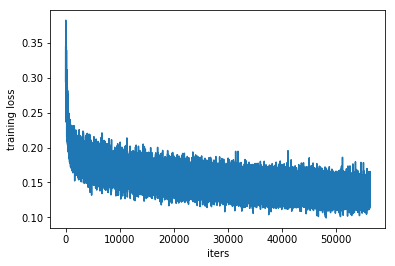

In [12]:
plt.figure()
plt.plot(train_loss_hist)
plt.xlabel('iters')
plt.ylabel('training loss')

Text(0,0.5,'validation loss')

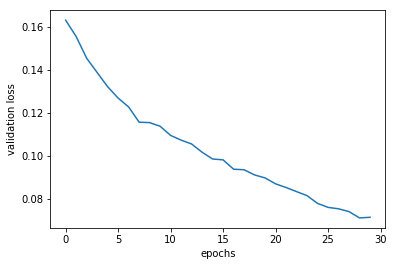

In [13]:
plt.figure()
plt.plot(val_loss_hist)
plt.xlabel('epochs')
plt.ylabel('validation loss')

In [23]:
data, labels = next(iter(train_loader))
labels = data[:]
mask, x, y = getRandomMask(data, 10)
data = data * mask

In [24]:
data = data.to(device)
out = model(data)
out = out.cpu().detach().numpy()
out.shape

(32, 1, 28, 28)

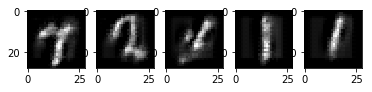

In [25]:
n = 5
for i in range(n):
    img = out[i]
    img = np.reshape(img, (28, 28))
    plt.subplot(3, n, i + 1)
    plt.imshow(img, cmap = 'gray')

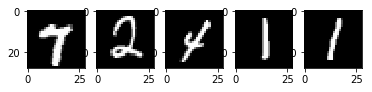

In [26]:
n = 5
for i in range(n):
    img = labels[i].cpu().detach().numpy()
    img = np.reshape(img, (28, 28))
    plt.subplot(1, n, i + 1)
    plt.imshow(img, cmap = 'gray')

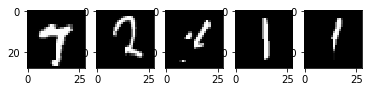

In [27]:
n = 5
for i in range(n):
    img = data[i].cpu().detach().numpy()
    img = np.reshape(img, (28, 28))
    plt.subplot(1, n, i + 1)
    plt.imshow(img, cmap = 'gray')